In [1]:
# Python import
import os
import copy
import random
import collections
import itertools
import numpy as np
import pandas as pd
import lightgbm as lgb
import warnings
import joblib
from sklearn.model_selection import train_test_split,RandomizedSearchCV
import sklearn.metrics as metrics
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
import lightgbm as lgb
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

In [2]:
import pandas as pd

# 创建评估结果数据
data = {
    'Model': ['circExor', 'RNAlocate-v3', 'exoGRU'],
    'AUROC': [0.7432, 0.5164, 0.5301],
    'AUPRC': [0.7842, 0.5084, 0.5157],
    'Accuracy': [0.6831, 0.5164, 0.5301],
    'F1_Score': [0.6848, 0.6481, 0.6037],
    'MCC': [0.3661, 0.0495, 0.0647]
}

# 创建DataFrame
results_df = pd.DataFrame(data)

# 显示表格
print(results_df)

# 保存为CSV文件
results_df.to_csv('./metircs.csv', index=False)

          Model   AUROC   AUPRC  Accuracy  F1_Score     MCC
0      circExor  0.7432  0.7842    0.6831    0.6848  0.3661
1  RNAlocate-v3  0.5164  0.5084    0.5164    0.6481  0.0495
2        exoGRU  0.5301  0.5157    0.5301    0.6037  0.0647


排序后的模型顺序（AUROC从低到高）:
1. RNAlocate-v3: AUROC = 0.5164
2. exoGRU: AUROC = 0.5301
3. circExor: AUROC = 0.7432


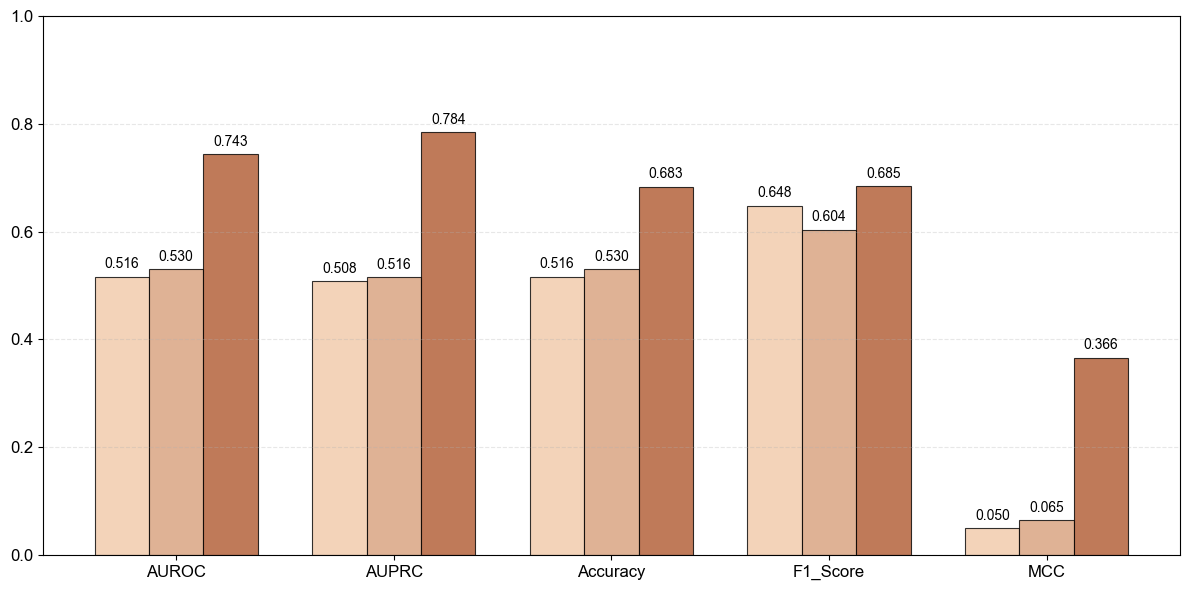

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 模型评估数据（原始顺序）
models_original = ['circExor', 'RNAlocate-v3', 'exoGRU']
metrics = ['AUROC', 'AUPRC', 'Accuracy', 'F1_Score', 'MCC']

# 数据矩阵 (模型 x 指标)
data_original = np.array([
    [0.7432, 0.7842, 0.6831, 0.6848, 0.3661],  # circExor
    [0.5164, 0.5084, 0.5164, 0.6481, 0.0495],  # RNAlocate-v3
    [0.5301, 0.5157, 0.5301, 0.6037, 0.0647]   # exoGRU
])

# 根据AUROC排序（从低到高）
auroc_values = data_original[:, 0]  # AUROC是第一列
sorted_indices = np.argsort(auroc_values)  # 从低到高排序的索引

# 重新排列模型和数据
models = [models_original[i] for i in sorted_indices]
data = data_original[sorted_indices]

print("排序后的模型顺序（AUROC从低到高）:")
for i, model in enumerate(models):
    print(f"{i+1}. {model}: AUROC = {data[i][0]:.4f}")

# 暖色调配色（从浅到深）
warm_colors = [
    '#F8D7B4', '#F0C9A8', '#E8BB99', '#D89F7B', '#C8835D', '#B05930'
]

# 为3个模型分配颜色（从浅到深，对应AUROC从低到高）
model_colors = [warm_colors[1], warm_colors[3], warm_colors[5]]  # 浅、中、深

# 设置图形参数
fig, ax = plt.subplots(figsize=(12, 6))
n_metrics = len(metrics)
n_models = len(models)
bar_width = 0.25
x = np.arange(n_metrics)

# 绘制分组柱状图
for i, model in enumerate(models):
    offset = (i - n_models/2 + 0.5) * bar_width
    bars = ax.bar(x + offset, data[i], bar_width, 
                  label=model, color=model_colors[i], 
                  edgecolor='black', linewidth=0.8, alpha=0.8)
    
    # 在柱子上添加数值标签
    for j, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{data[i][j]:.3f}', ha='center', va='bottom', fontsize=10)

# 设置图形属性
# ax.set_xlabel('Metrics', fontsize=14)
# ax.set_ylabel('Score', fontsize=14)
# ax.set_title('Model Performance Comparison', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.set_ylim(0, max(data.max() * 1.1, 1.0))
ax.grid(axis='y', alpha=0.3, linestyle='--')
# ax.legend(fontsize=12, loc='upper right')

# 调整布局
plt.tight_layout()
plt.show()

排序后的模型顺序（AUROC从低到高）:
1. RNAlocate-v3: AUROC = 0.5164
2. exoGRU: AUROC = 0.5301
3. circExor: AUROC = 0.7432


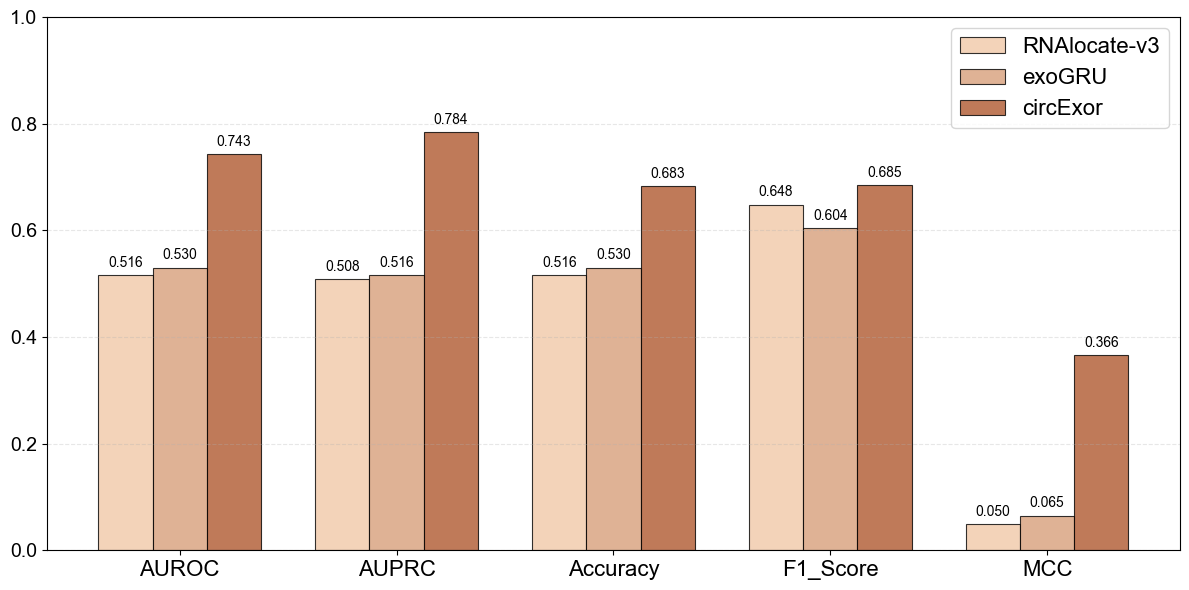

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 模型评估数据（原始顺序）
models_original = ['circExor', 'RNAlocate-v3', 'exoGRU']
metrics = ['AUROC', 'AUPRC', 'Accuracy', 'F1_Score', 'MCC']

# 数据矩阵 (模型 x 指标)
data_original = np.array([
    [0.7432, 0.7842, 0.6831, 0.6848, 0.3661],  # circExor
    [0.5164, 0.5084, 0.5164, 0.6481, 0.0495],  # RNAlocate-v3
    [0.5301, 0.5157, 0.5301, 0.6037, 0.0647]   # exoGRU
])

# 根据AUROC排序（从低到高）
auroc_values = data_original[:, 0]  # AUROC是第一列
sorted_indices = np.argsort(auroc_values)  # 从低到高排序的索引

# 重新排列模型和数据
models = [models_original[i] for i in sorted_indices]
data = data_original[sorted_indices]

print("排序后的模型顺序（AUROC从低到高）:")
for i, model in enumerate(models):
    print(f"{i+1}. {model}: AUROC = {data[i][0]:.4f}")

# 暖色调配色（从浅到深）
warm_colors = [
    '#F8D7B4', '#F0C9A8', '#E8BB99', '#D89F7B', '#C8835D', '#B05930'
]

# 为3个模型分配颜色（从浅到深，对应AUROC从低到高）
model_colors = [warm_colors[1], warm_colors[3], warm_colors[5]]  # 浅、中、深

# 设置图形参数
fig, ax = plt.subplots(figsize=(12, 6))
n_metrics = len(metrics)
n_models = len(models)
bar_width = 0.25
x = np.arange(n_metrics)

# 绘制分组柱状图
for i, model in enumerate(models):
    offset = (i - n_models/2 + 0.5) * bar_width
    bars = ax.bar(x + offset, data[i], bar_width, 
                  label=model, color=model_colors[i], 
                  edgecolor='black', linewidth=0.8, alpha=0.8)
    
    # 在柱子上添加数值标签
    for j, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{data[i][j]:.3f}', ha='center', va='bottom', fontsize=10)

# 设置图形属性
# ax.set_xlabel('Metrics', fontsize=14)
# ax.set_ylabel('Score', fontsize=14)
# ax.set_title('Model Performance Comparison', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=16)
ax.tick_params(axis='y', labelsize=14)
ax.set_ylim(0, max(data.max() * 1.1, 1.0))
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.legend(fontsize=16, loc='upper right')

# 调整布局
plt.tight_layout()
plt.show()

图例模型顺序（AUROC从低到高）:
1. RNAlocate-v3: AUROC = 0.5164
2. exoGRU: AUROC = 0.5301
3. circExor: AUROC = 0.7432


/tmp/ipykernel_82432/651499101.py:58: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


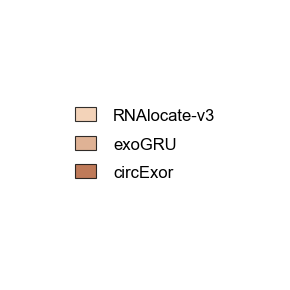

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# ===== 输入数据 =====
# 模型名称（按AUROC从低到高排序，与主图保持一致）
models_original = ['circExor', 'RNAlocate-v3', 'exoGRU']
auroc_values = [0.7432, 0.5164, 0.5301]  # 对应的AUROC值

# 根据AUROC排序（从低到高）
sorted_indices = np.argsort(auroc_values)
models = [models_original[i] for i in sorted_indices]

print("图例模型顺序（AUROC从低到高）:")
for i, model in enumerate(models):
    print(f"{i+1}. {model}: AUROC = {auroc_values[sorted_indices[i]]:.4f}")

# 配色方案 - 使用暖色调（与性能比较图保持一致）
warm_colors = [
    '#F8D7B4', '#F0C9A8', '#E8BB99', '#D89F7B', '#C8835D', '#B05930'
]

# 为3个模型分配颜色（从浅到深，对应AUROC从低到高）
model_colors = [warm_colors[1], warm_colors[3], warm_colors[5]]  # 浅、中、深

# ===== 公共绘图函数 =====
def plot_model_legend(models, colors, filename, labelspacing=0.6, markersize=12, figsize=(3, 3)):
    """
    绘制模型与颜色对应的图例，并保存为透明背景图片
    专门用于分组柱状图
    """
    plt.rcParams['font.family'] = 'Arial'
    fig, ax = plt.subplots(figsize=figsize)

    handles = []
    for model, color in zip(models, colors):
        # 使用矩形标记，适合分组柱状图
        patch = plt.Rectangle(
            (0, 0), 1, 1, facecolor=color, 
            edgecolor='black', linewidth=0.8,
            alpha=0.8,  # 与主图保持一致的透明度
            label=model
        )
        handles.append(patch)

    legend = ax.legend(
        handles=handles,
        labels=models,
        loc='center',
        ncol=1,
        frameon=False,
        labelspacing=labelspacing,  # 控制行间距
        handlelength=1.5,           # 图例标记长度
        handletextpad=0.8,          # 标记与文本间距
        fontsize=12                 # 字体大小
    )
    
    # 设置图例中矩形的大小
    for handle in legend.legendHandles:
        handle.set_width(markersize/10)
        handle.set_height(markersize/15)
    
    ax.axis('off')

    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight', transparent=True)
    plt.show()

# 调用函数生成图例
plot_model_legend(models, model_colors, "model_comparison_legend.png", labelspacing=0.8, markersize=150)

雷达图模型顺序（AUROC从低到高）:
1. RNAlocate-v3: AUROC = 0.5164
2. exoGRU: AUROC = 0.5301
3. circExor: AUROC = 0.7432


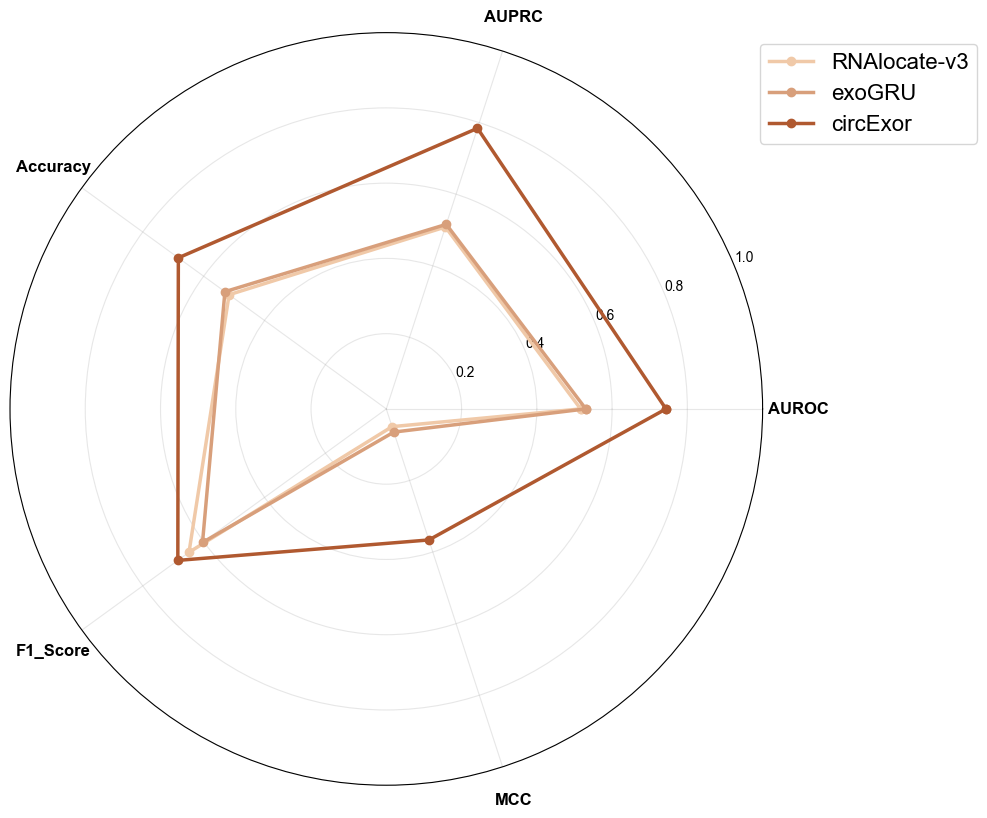

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# 三个模型数据（按AUROC从低到高排序）
models_original = ['circExor', 'RNAlocate-v3', 'exoGRU']
auroc_values = [0.7432, 0.5164, 0.5301]

# 根据AUROC排序（从低到高）
sorted_indices = np.argsort(auroc_values)
selected_models = [models_original[i] for i in sorted_indices]

# 重新排列数据（按排序后的模型顺序）
original_data = np.array([
    [0.7432, 0.7842, 0.6831, 0.6848, 0.3661],  # circExor [AUROC, AUPRC, Accuracy, F1_Score, MCC]
    [0.5164, 0.5084, 0.5164, 0.6481, 0.0495],  # RNAlocate-v3
    [0.5301, 0.5157, 0.5301, 0.6037, 0.0647]   # exoGRU
])

# 按排序重新组织数据
radar_data = original_data[sorted_indices]

# 雷达图指标（保持与原数据一致）
metrics = ['AUROC', 'AUPRC', 'Accuracy', 'F1_Score', 'MCC']

print("雷达图模型顺序（AUROC从低到高）:")
for i, model in enumerate(selected_models):
    print(f"{i+1}. {model}: AUROC = {radar_data[i][0]:.4f}")

# 使用暖色配色方案（从浅到深，对应AUROC从低到高）
warm_colors = [
    '#F8D7B4', '#F0C9A8', '#E8BB99', '#D89F7B', '#C8835D', '#B05930'
]
radar_colors = [warm_colors[1], warm_colors[3], warm_colors[5]]  # 浅、中、深

# 计算角度
angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False)
angles = np.concatenate((angles, [angles[0]]))  # 闭合雷达图

# 创建雷达图
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

# 为每个模型绘制雷达线
for i, model in enumerate(selected_models):
    values = np.concatenate((radar_data[i], [radar_data[i][0]]))  # 闭合数据
    ax.plot(angles, values, 'o-', linewidth=2.5, label=model, 
            color=radar_colors[i], markersize=6)

# 设置雷达图属性
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics, fontsize=12, fontweight='bold')
ax.set_ylim(0, 1.0)  # 调整上限适应数据范围
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=10)
ax.grid(True, alpha=0.3)

# 调整标签位置
ax.tick_params(axis='x', pad=15)  # 增加标签与轴的距离

# 设置图例
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=16)

# 调整布局
plt.tight_layout()
plt.show()

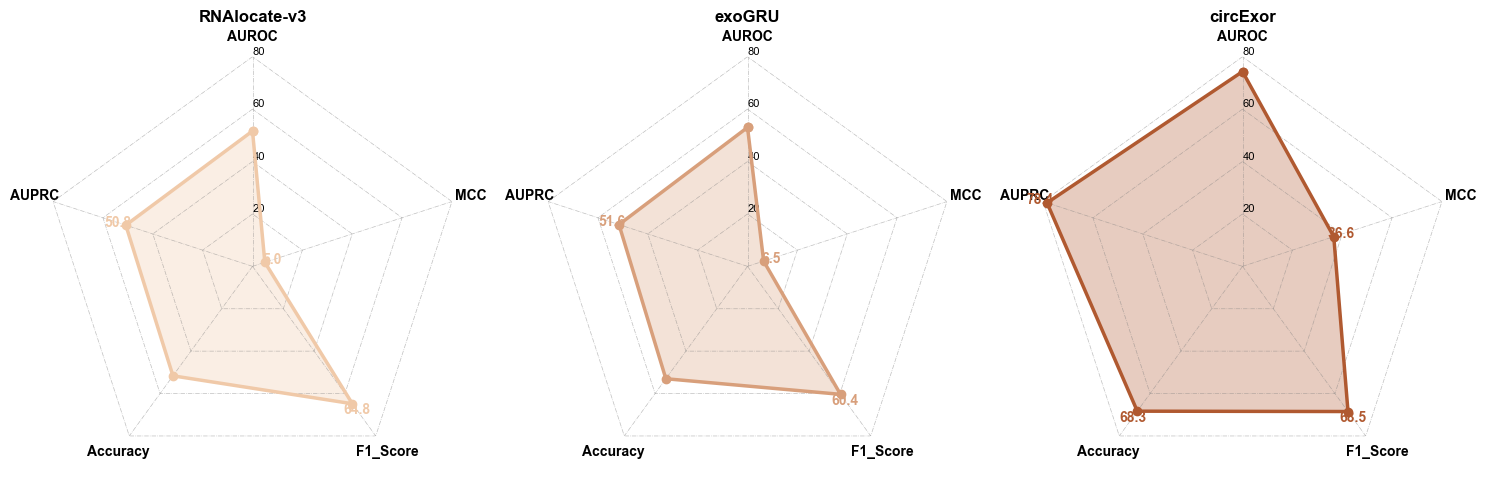

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# 三个模型的数据（转换为0-100的分数以便显示）
results = [
    {"AUROC": 51.64, "AUPRC": 50.84, "Accuracy": 51.64, "F1_Score": 64.81, "MCC": 4.95},  # RNAlocate-v3
    {"AUROC": 53.01, "AUPRC": 51.57, "Accuracy": 53.01, "F1_Score": 60.37, "MCC": 6.47},  # exoGRU
    {"AUROC": 74.32, "AUPRC": 78.42, "Accuracy": 68.31, "F1_Score": 68.48, "MCC": 36.61}  # circExor
]

# 模型名称
model_names = ["RNAlocate-v3", "exoGRU", "circExor"]

# 使用暖色配色方案（从浅到深）
warm_colors = ['#F0C9A8', '#D89F7B', '#B05930']

data_length = len(results[0])
angles = np.linspace(0, 2*np.pi, data_length, endpoint=False)
labels = [key for key in results[0].keys()]
score = [[v for v in result.values()] for result in results]

# 为每个模型创建闭合数据
score_closed = []
for i in range(3):
    score_closed.append(np.concatenate((score[i], [score[i][0]])))

angles = np.concatenate((angles, [angles[0]]))
labels = np.concatenate((labels, [labels[0]]))

fig = plt.figure(figsize=(15, 5), dpi=100)
# fig.suptitle("Model Performance Comparison", fontsize=16, fontweight='bold')

# 创建三个子图
ax1 = plt.subplot(131, polar=True)
ax2 = plt.subplot(132, polar=True)
ax3 = plt.subplot(133, polar=True)

ax = [ax1, ax2, ax3]

for i in range(3):
    # 绘制网格线
    for j in np.arange(0, 80+20, 20):
        ax[i].plot(angles, 6*[j], '-.', lw=0.5, color='gray', alpha=0.5)
    for j in range(5):
        ax[i].plot([angles[j], angles[j]], [0, 80], '-.', lw=0.5, color='gray', alpha=0.5)
    
    # 绘制数据线和填充
    ax[i].plot(angles, score_closed[i], color=warm_colors[i], linewidth=2.5, marker='o', markersize=6)
    ax[i].fill(angles, score_closed[i], color=warm_colors[i], alpha=0.3)
    
    # 隐藏最外圈的圆
    ax[i].spines['polar'].set_visible(False)
    # 隐藏圆形网格线
    ax[i].grid(False)
    
    # 添加数值标签
    for a, b in zip(angles, score_closed[i]):
        if b == score_closed[i][-1]:  # 跳过重复的最后一个点
            continue
        ax[i].text(a, b+3, '%.1f' % b, ha='center', va='center', fontsize=10, 
                  color=warm_colors[i], fontweight='bold')
    
    # 设置角度标签
    ax[i].set_thetagrids(angles[:-1]*180/np.pi, labels[:-1], fontsize=10, fontweight='bold')
    ax[i].set_theta_zero_location('N')  # 从顶部开始
    ax[i].set_rlim(0, 80)
    ax[i].set_rlabel_position(0)
    ax[i].set_title(model_names[i], fontsize=12, fontweight='bold', color='black')
    
    # 设置径向标签
    ax[i].set_yticks([20, 40, 60, 80])
    ax[i].set_yticklabels(['20', '40', '60', '80'], fontsize=8)

plt.tight_layout()
plt.show()

<Figure size 500x1000 with 0 Axes>

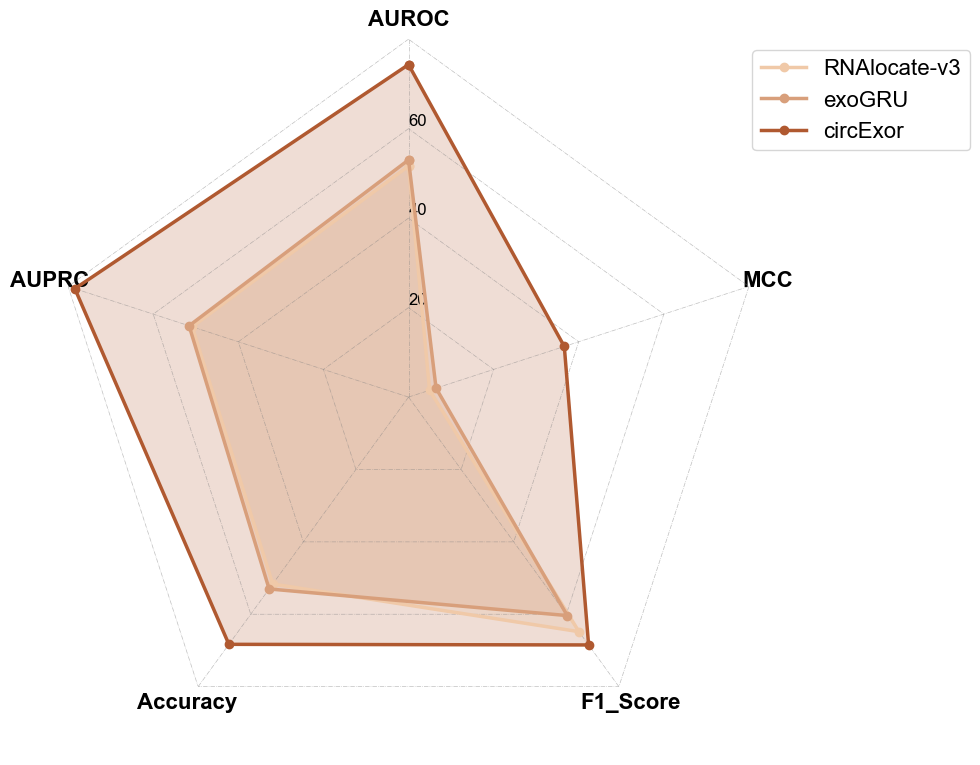

In [22]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 10), dpi=100)
# 三个模型的数据（转换为0-100的分数以便显示）
results = [
    {"AUROC": 51.64, "AUPRC": 50.84, "Accuracy": 51.64, "F1_Score": 64.81, "MCC": 4.95},  # RNAlocate-v3
    {"AUROC": 53.01, "AUPRC": 51.57, "Accuracy": 53.01, "F1_Score": 60.37, "MCC": 6.47},  # exoGRU
    {"AUROC": 74.32, "AUPRC": 78.42, "Accuracy": 68.31, "F1_Score": 68.48, "MCC": 36.61}  # circExor
]

# 模型名称
model_names = ["RNAlocate-v3", "exoGRU", "circExor"]

# 使用暖色配色方案（从浅到深）
warm_colors = ['#F0C9A8', '#D89F7B', '#B05930']

data_length = len(results[0])
angles = np.linspace(0, 2*np.pi, data_length, endpoint=False)
labels = [key for key in results[0].keys()]
score = [[v for v in result.values()] for result in results]

# 为每个模型创建闭合数据
score_closed = []
for i in range(3):
    score_closed.append(np.concatenate((score[i], [score[i][0]])))

angles = np.concatenate((angles, [angles[0]]))
labels = np.concatenate((labels, [labels[0]]))

# 创建单个雷达图
fig = plt.figure(figsize=(10, 10), dpi=100)
ax = plt.subplot(111, polar=True)

# 绘制网格线
for j in np.arange(0, 80+20, 20):
    ax.plot(angles, 6*[j], '-.', lw=0.5, color='gray', alpha=0.5)
for j in range(5):
    ax.plot([angles[j], angles[j]], [0, 80], '-.', lw=0.5, color='gray', alpha=0.5)

# 绘制三个模型的数据
for i in range(3):
    # 绘制数据线和填充
    ax.plot(angles, score_closed[i], color=warm_colors[i], linewidth=2.5, 
            marker='o', markersize=6, label=model_names[i])
    ax.fill(angles, score_closed[i], color=warm_colors[i], alpha=0.2)

# 隐藏最外圈的圆
ax.spines['polar'].set_visible(False)
# 隐藏圆形网格线
ax.grid(False)

# 设置角度标签
ax.set_thetagrids(angles[:-1]*180/np.pi, labels[:-1], fontsize=16, fontweight='bold')
ax.set_theta_zero_location('N')  # 从顶部开始
ax.set_rlim(0, 80)
ax.set_rlabel_position(0)

# 设置径向标签
ax.set_yticks([20, 40, 60])
ax.set_yticklabels(['20', '40', '60'], fontsize=12)

# 添加图例
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=16)

# 设置标题
# plt.title("Model Performance Comparison", fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

<Figure size 500x1000 with 0 Axes>

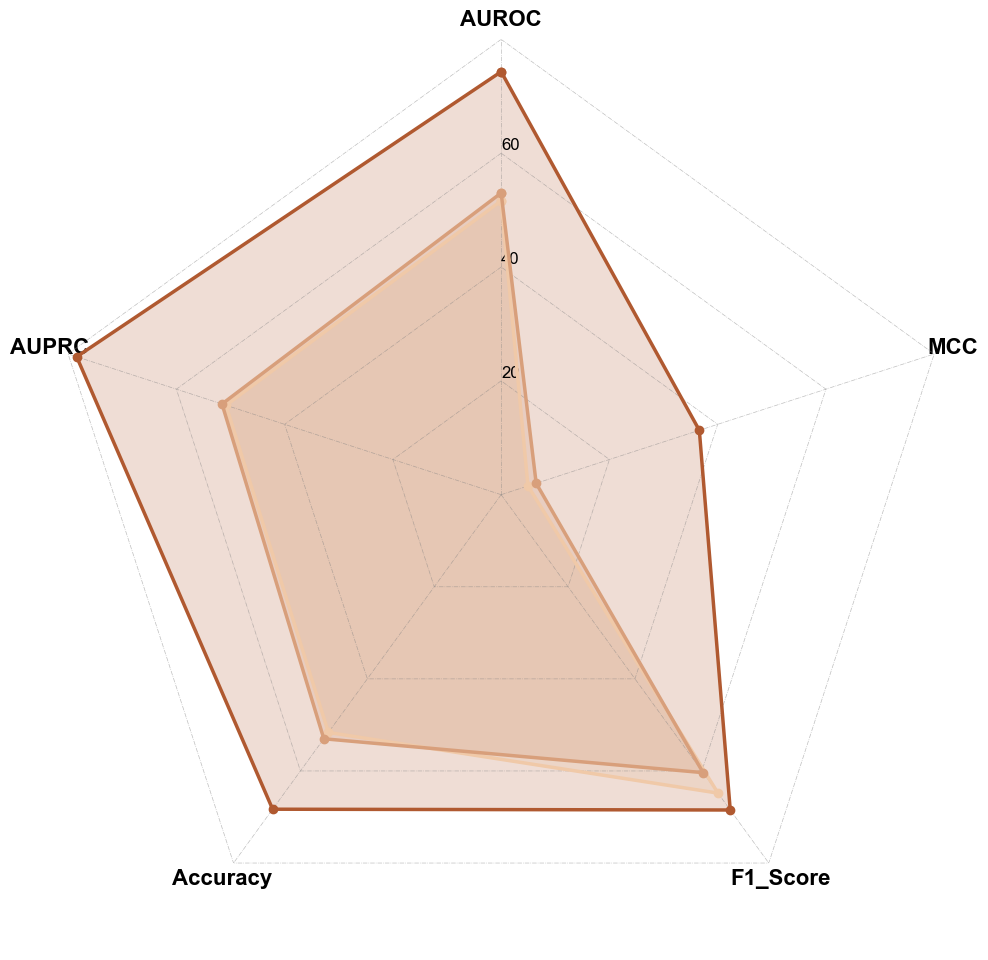

In [23]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 10), dpi=100)
# 三个模型的数据（转换为0-100的分数以便显示）
results = [
    {"AUROC": 51.64, "AUPRC": 50.84, "Accuracy": 51.64, "F1_Score": 64.81, "MCC": 4.95},  # RNAlocate-v3
    {"AUROC": 53.01, "AUPRC": 51.57, "Accuracy": 53.01, "F1_Score": 60.37, "MCC": 6.47},  # exoGRU
    {"AUROC": 74.32, "AUPRC": 78.42, "Accuracy": 68.31, "F1_Score": 68.48, "MCC": 36.61}  # circExor
]

# 模型名称
model_names = ["RNAlocate-v3", "exoGRU", "circExor"]

# 使用暖色配色方案（从浅到深）
warm_colors = ['#F0C9A8', '#D89F7B', '#B05930']

data_length = len(results[0])
angles = np.linspace(0, 2*np.pi, data_length, endpoint=False)
labels = [key for key in results[0].keys()]
score = [[v for v in result.values()] for result in results]

# 为每个模型创建闭合数据
score_closed = []
for i in range(3):
    score_closed.append(np.concatenate((score[i], [score[i][0]])))

angles = np.concatenate((angles, [angles[0]]))
labels = np.concatenate((labels, [labels[0]]))

# 创建单个雷达图
fig = plt.figure(figsize=(10, 10), dpi=100)
ax = plt.subplot(111, polar=True)

# 绘制网格线
for j in np.arange(0, 80+20, 20):
    ax.plot(angles, 6*[j], '-.', lw=0.5, color='gray', alpha=0.5)
for j in range(5):
    ax.plot([angles[j], angles[j]], [0, 80], '-.', lw=0.5, color='gray', alpha=0.5)

# 绘制三个模型的数据
for i in range(3):
    # 绘制数据线和填充
    ax.plot(angles, score_closed[i], color=warm_colors[i], linewidth=2.5, 
            marker='o', markersize=6, label=model_names[i])
    ax.fill(angles, score_closed[i], color=warm_colors[i], alpha=0.2)

# 隐藏最外圈的圆
ax.spines['polar'].set_visible(False)
# 隐藏圆形网格线
ax.grid(False)

# 设置角度标签
ax.set_thetagrids(angles[:-1]*180/np.pi, labels[:-1], fontsize=16, fontweight='bold')
ax.set_theta_zero_location('N')  # 从顶部开始
ax.set_rlim(0, 80)
ax.set_rlabel_position(0)

# 设置径向标签
ax.set_yticks([20, 40, 60])
ax.set_yticklabels(['20', '40', '60'], fontsize=12)

# 添加图例
# ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=16)

# 设置标题
# plt.title("Model Performance Comparison", fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()